In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row

In [3]:
# env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
# kz.utils.set_env(**env_dict)

env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/tigress/jiaxuanl/Data/HSC/LSBG'

In [4]:
lsbg_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')
lsbg_cat.sort('viz-id')

### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

In [6]:
import sys
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [7]:
from vanilla_measure_all import measure_vanilla
from kuaizi.measure import initialize_meas_cat, makeMeasurement
from tqdm import trange

In [13]:
suffix = 'nosegmap'
meas_cat_all = Table.read(f'./Catalog/nsa_z002_004/_lsbg_meas_vanilla_1k_{suffix}.fits')
meas_cat_all[1000:2000] = Table.read(f'./Catalog/nsa_z002_004/_lsbg_meas_vanilla_2k_{suffix}.fits')[1000:2000]
meas_cat_all[2000:3000] = Table.read(f'./Catalog/nsa_z002_004/_lsbg_meas_vanilla_3k_{suffix}.fits')[2000:3000]
meas_cat_all[3000:4000] = Table.read(f'./Catalog/nsa_z002_004/_lsbg_meas_vanilla_4k_{suffix}.fits')[3000:4000]
meas_cat_all[4000:5000] = Table.read(f'./Catalog/nsa_z002_004/_lsbg_meas_vanilla_5k_{suffix}.fits')[4000:5000]
meas_cat_all[5000:] = Table.read(f'./Catalog/nsa_z002_004/_lsbg_meas_vanilla_6k_{suffix}.fits')[5000:]
meas_cat_all.write(f'./Catalog/nsa_z002_004/lsbg_meas_vanilla_{suffix}_all.fits', overwrite=True)
failed_meas_ind = lsbg_cat[(np.isnan(meas_cat_all['rhalf_circularized']))]['viz-id'].data
len(failed_meas_ind)

63

In [18]:
incomplete_file_ind = np.array([  462,  4081,  6161,  8176,  7406,  9498, 12637, 38550,
       40895, 38890, 36497, 42403, 47032, 48071, 48284,
       48689, 61669, 59005, 60514, 63338, 62688, 83009,
       84001, 87524, 88927, 85773, 88419, 89528])

In [20]:
# np.in1d(failed_meas_ind, incomplete_file_ind)

In [39]:
from kuaizi.measure import makeMeasurement

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

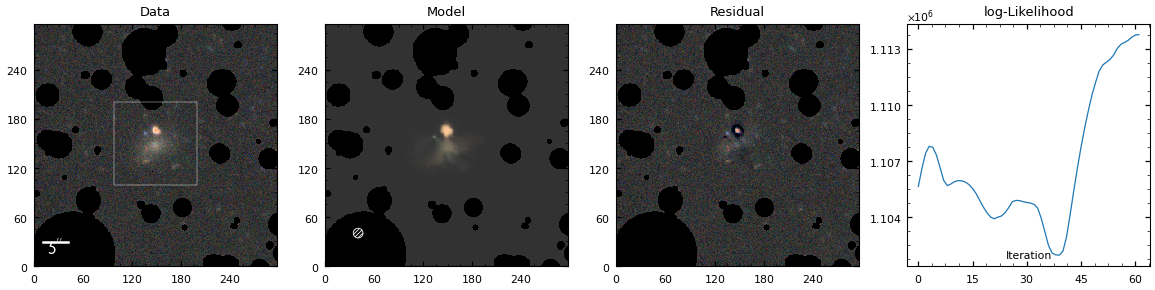

In [181]:
ind = 57828
with open(f'/tigress/jiaxuanl/Data/HSC/LSBG/Model/nsa_z002_004/nsa-{ind}-trained-model-vanilla.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_model(
    blend,
    show_ind=[0],
    zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=True,
    show_mark=False, 
    show_loss=True)

In [182]:
_temp = meas_cat[meas_cat['ID'] == ind]
print('SB_eff_avg', _temp['SB_eff_avg'].data)
print('rhalf_nosegmap', _temp['rhalf_circularized'].data * 0.168)
_temp = seg_meas_cat[meas_cat['ID'] == ind]
print('rhalf_segmap', _temp['rhalf_circularized'].data * 0.168)

SB_eff_avg [[26.33909416 25.59964371 25.09626198 24.89286041]]
rhalf_nosegmap [3.04730183]
rhalf_segmap [2.09702582]


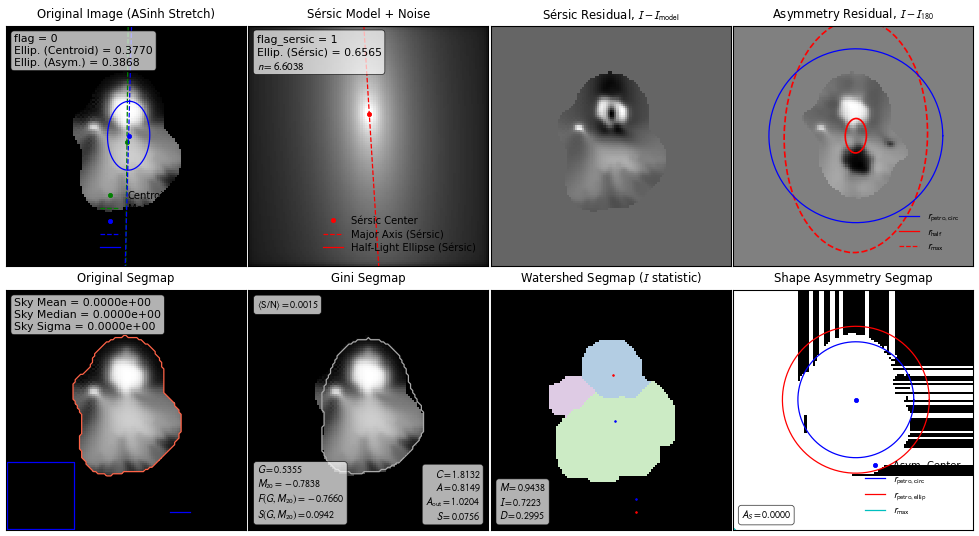

In [183]:
measurement, _ = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 makesegmap=True, sigma=1,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)

In [140]:
measurement['rhalf_circularized'] * 0.168

2.3573190663459678

In [184]:
meas_cat[meas_cat['ID'] == ind]

ID,flux [4],mag [4],flux_circ [4],flux_ellip [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],SB_eff_avg [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,rhalf_circularized,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
57828,107.24481201171875 .. 406.32177734375,21.92405891418457 .. 20.477825164794922,107.24068450927734 .. 406.30615234375,107.23250579833984 .. 406.275146484375,24.701522827148438 .. 23.25528907775879,26.591712951660156 .. 25.145479202270508,26.56886863708496 .. 25.122634887695312,26.339094161987305 .. 24.892860412597656,54.51808677719942,54.91421676715639,56.29630361070589,50.798706370207725,0.09912307853765734,0.08473611998843922,0.956450938129914,1.197076822447172,18.414137856519492,18.959768439476903,18.13870136838941,9.738809219741151,18.354956049728948,25.45334860681619,0.5519956005989737,-0.8081664840476612,-0.6675624035900514,0.10714050331035901,2.086195336906931,0.8939321874429946,1.3104713906772307,0.27056724793526976,0.06563908674432622,1.0,18.959768439476903,0.08473611998843922,1.197076822447172,56.29630361070589,50.798706370207725,0.042594776688744,1.0,1.0


### Analysis

In [14]:
import kuaizi
from kuaizi.display import plot_measurement
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)

In [15]:
meas_cat = Table.read('./Catalog/nsa_z002_004/lsbg_meas_vanilla_nosegmap_all.fits')
seg_meas_cat = Table.read('./Catalog/nsa_z002_004/lsbg_meas_vanilla_segmap_all.fits')
# old_meas_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/NSA/z002_004/lsbg_measure_vanilla_all.fits')

In [16]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

(19.0, 29.0)

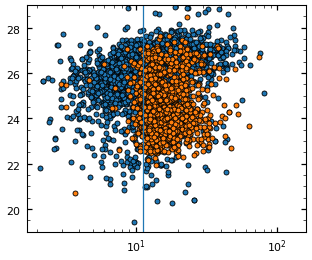

In [17]:
plt.scatter(meas_cat['rhalf_circularized'][junk], meas_cat['SB_eff_avg'][:, 0][junk])
plt.scatter(meas_cat['rhalf_circularized'][candy], meas_cat['SB_eff_avg'][:, 0][candy])
# plt.scatter(meas_cat['r20'][gal], meas_cat['SB_eff_avg'][:, 0][gal])

plt.axvline(1.9 / 0.168)
plt.xscale('log')
plt.ylim(19, 29)

(19.0, 29.0)

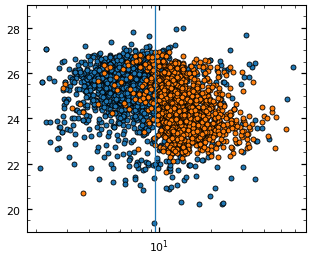

In [18]:
plt.scatter(seg_meas_cat['rhalf_circularized'][junk], seg_meas_cat['SB_eff_avg'][:, 0][junk])
plt.scatter(seg_meas_cat['rhalf_circularized'][candy], seg_meas_cat['SB_eff_avg'][:, 0][candy])

plt.axvline(1.6 / 0.168)
plt.xscale('log')
plt.ylim(19, 29)

In [19]:
plt.scatter(meas_cat['rhalf_circularized'][candy & mask], meas_cat['SB_eff_avg'][:, 0][candy & mask])
plt.scatter(meas_cat['rhalf_circularized'][junk & mask], meas_cat['SB_eff_avg'][:, 0][junk & mask])

plt.axvline(0.8 / 0.168)
plt.ylim(19, 29)

NameError: name 'mask' is not defined

In [20]:
r_diff = (meas_cat['rhalf_circularized'] - seg_meas_cat['rhalf_circularized']).data  * 0.168

(-1.0, 15.0)

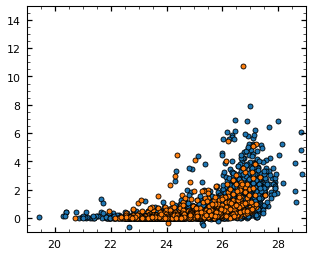

In [21]:
plt.scatter(meas_cat['SB_eff_avg'][:, 0][junk], r_diff[junk])
plt.scatter(meas_cat['SB_eff_avg'][:, 0][candy], r_diff[candy])


plt.xlim(19, 29)
plt.ylim(-1, 15)

(29.0, 24.0)

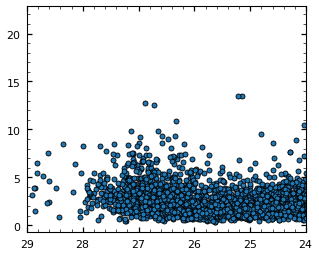

In [22]:
plt.scatter(meas_cat['SB_eff_avg'][:, 0], meas_cat['rhalf_circularized'] * 0.168)
plt.xlim(29, 24)

(28.0, 24.0)

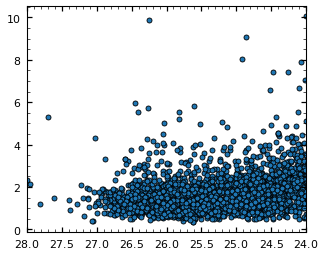

In [23]:
plt.scatter(seg_meas_cat['SB_eff_avg'][:, 0], seg_meas_cat['rhalf_circularized'] * 0.168)
plt.xlim(28, 24)

# of Candy: 1276
# of Gal: 2404
# of Junk: 1896


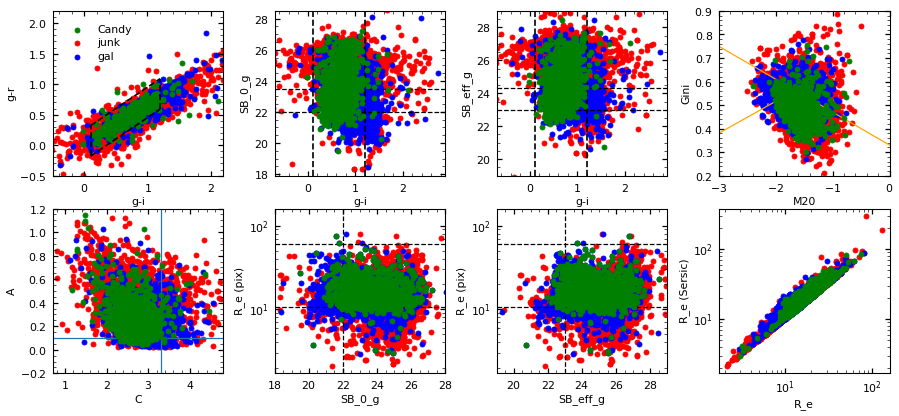

In [24]:
plot_measurement(lsbg_cat, meas_cat) # old

# of Candy: 1276
# of Gal: 2404
# of Junk: 1896


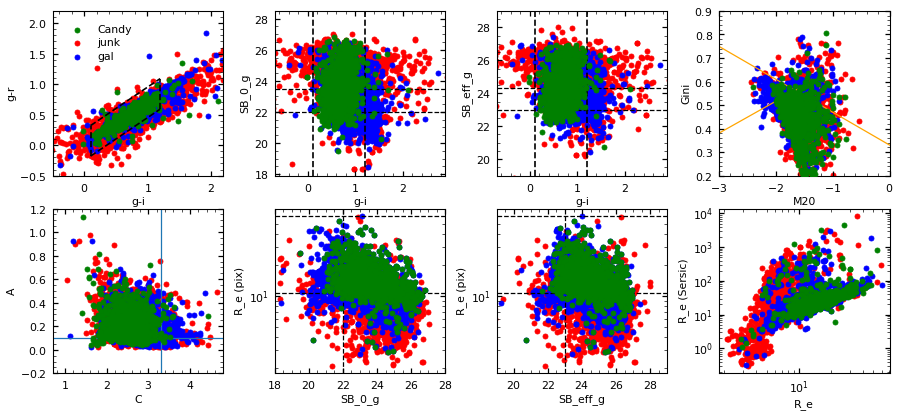

In [25]:
plot_measurement(lsbg_cat, seg_meas_cat)

In [26]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [293]:
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['rhalf_circularized'] > 2.0 / 0.168) & (meas_cat['rhalf_circularized'] < 12 / 0.168)

mask &= (meas_cat['SB_0'][:, 0] > 22.0)

#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.8) # Cuts based on JL votes
#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.) # Cuts based on JG votes
mask &= (meas_cat['SB_eff_avg'][:, 0] > 23.0) # Cuts based on JG votes
#mask &= (meas_cat['SB_eff_avg'][:, 0] < 27.)

mask &= (meas_cat['ell_sym'] < 0.65)

# mask &= (meas_cat['M20'] < -1.1)
# mask &= (meas_cat['Gini'] < 0.7)
# mask &= ~((meas_cat['M20'] < -1.6) & (
#     meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))
#mask &= (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.37)

mask &= (meas_cat['C'] < 3.5) & (meas_cat['C'] > 1.8)
#mask &= (meas_cat['A_outer'] <= 0.13)

mask &= (seg_meas_cat['rhalf_circularized'] > 1.8 / 0.168) & (seg_meas_cat['rhalf_circularized'] < 12 / 0.168)

print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 826
Gal: 744
Junk: 79


# of Candy: 824
# of Gal: 744
# of Junk: 73


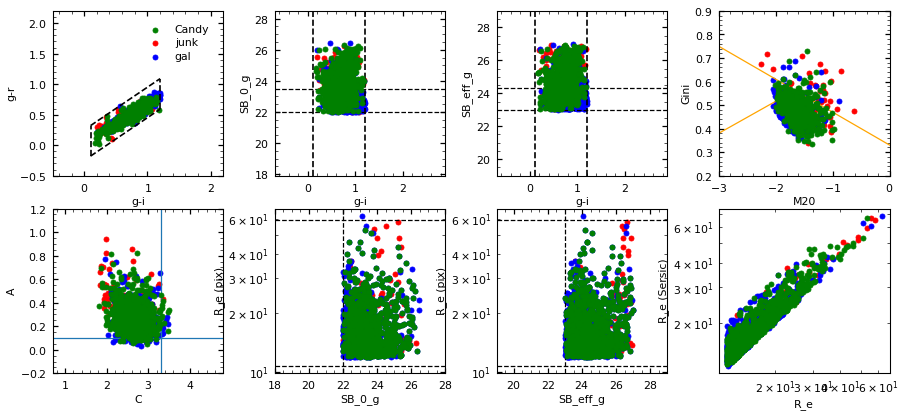

In [101]:
plot_measurement(lsbg_cat[mask], meas_cat[mask])

### Save catalog

In [102]:
# lsbg_cat['host_RA'] = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004.fits')[100:]['host_RA']
# lsbg_cat['host_DEC'] = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004.fits')[100:]['host_DEC']

In [294]:
from astropy.table import hstack
hstack([lsbg_cat[mask], meas_cat[mask]]
      ).write('./Catalog/nsa_z002_004/lsbg_NSA_MW_z002_004_after_cuts_new.fits', overwrite=True)

In [331]:
cuts_cat = Table.read('./Catalog/nsa_z002_004/lsbg_NSA_MW_z002_004_after_cuts_new.fits')
# cuts_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004_after_cuts_JG.fits')

cuts_cat['mag_circ'] = -2.5 * np.log10(cuts_cat['flux_circ']) + 27.0

In [332]:
len(cuts_cat)

1649

In [333]:
from astropy.coordinates import SkyCoord

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

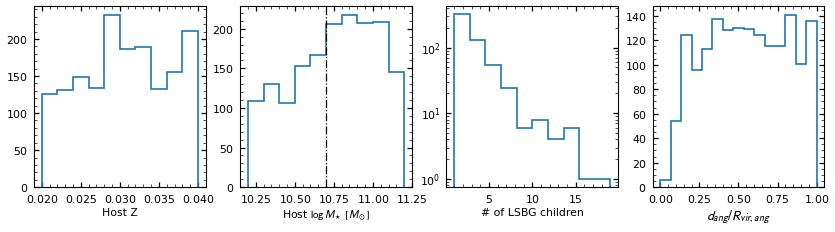

In [334]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2);
plt.xlabel('Host Z')

plt.sca(axes[1])
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2);
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(cuts_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')
host_coord = SkyCoord(cuts_cat['host_RA'], cuts_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / cuts_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=15, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

In [335]:
ang_diam_dist = cuts_cat['host_ang_diam_dist'] # not consider peculiar motion

rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_circularized_phys'] = rhalf_phys

rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_ellip_phys'] = rhalf_phys

In [336]:
cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
log_ML_V = 1.493 * BV - 0.681
M = (4.83 - V_abs) / (2.5) + log_ML_V
cuts_cat['log_m_star'] = M
cuts_cat['V_abs'] = V_abs

In [337]:
### UDGs
flag = (cuts_cat['rhalf_circularized_phys'] > 1.5) & (cuts_cat['SB_0'][:, 0] >= 24.)# & (cuts_cat['sersic_ell'] < 0.7)
print('# of UDGs:', np.sum(flag))

# of UDGs: 222


In [338]:
udg_cat = cuts_cat[flag]

In [339]:
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/udg_z002_004_new_new.txt', 
    format='ascii')

In [340]:
# udg_cat.write('./Catalog/nsa_z002_004/UDG_NSA_MW_z002_004.fits', overwrite=True)

In [341]:
### Then I vote

In [342]:
temp = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/udg_visual_inspec.txt', format='ascii')
temp[temp['marked'] == 'true']['viz-id'].data
viz_flag = np.in1d(udg_cat['viz-id'], temp[temp['marked'] == 'true']['viz-id'].data)

In [343]:
udg_cat = udg_cat[~viz_flag]

In [344]:
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/udg_z002_004_new_new.txt', 
    format='ascii')

In [345]:
old_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/udg_z002_004.txt', format='ascii')
old_id = old_cat['viz-id'].data

In [346]:
old_cat[~np.in1d(old_id, udg_cat['viz-id'].data)
       ].write('/tigress/jiaxuanl/public_html/galary/catalogs/udg_z002_004_missed.txt', format='ascii')

In [347]:
missed_id = old_cat[~np.in1d(old_id, udg_cat['viz-id'].data)
       ]['viz-id'].data
missed_id

array([ 6675, 18077, 22086, 29725, 32512, 33394, 48838, 57828, 64638,
       72306, 74461, 74926, 76145, 82983, 83554, 90593])

In [348]:
print('Total hosts:', len(np.unique(lsbg_cat['host_name'])))
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UDGs:', len(udg_cat))
print('UDG hosts:', len(np.unique(udg_cat['host_name'])))

print('UDG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167

Total hosts: 754
Hosts for LSBGs after cuts: 557

LSBGs after cuts: 1649
UDGs: 201
UDG hosts: 148
UDG fraction: 0.3608617594254937


In [367]:
udg_cat.write('./Catalog/nsa_z002_004/UDG_NSA_MW_z002_004_new.fits', overwrite=True)

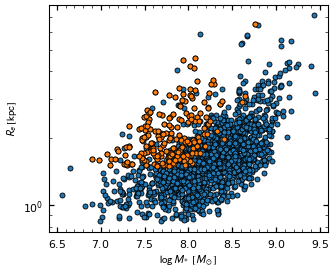

In [349]:
plt.scatter(cuts_cat['log_m_star'], cuts_cat['rhalf_circularized_phys'])
plt.scatter(udg_cat['log_m_star'], udg_cat['rhalf_circularized_phys'])

plt.xlabel(r'$\log\, M_*\ [M_\odot]$')
plt.ylabel(r'$R_e\ [\rm kpc]$')

plt.yscale('log')

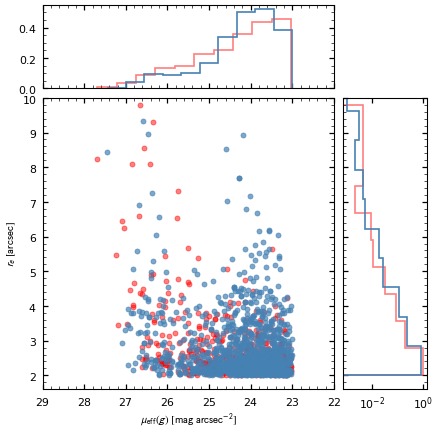

In [350]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((cuts_cat['mag_circ'][:, 0] - cuts_cat['mag_circ'][:, 2]) > 0.8)

ax.scatter(cuts_cat[red]['SB_eff_avg'][:, 0], 
           cuts_cat[red]['rhalf_circularized'] * 0.168, 
           color='r', alpha=0.5)
ax.scatter(cuts_cat[~red]['SB_eff_avg'][:, 0], 
            cuts_cat[~red]['rhalf_circularized'] * 0.168,
            color='steelblue', alpha=0.7)
ax.set_xlim(29, 22)
ax.set_ylim(1.6, 10)
ax.set_xlabel(r'$\mu_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(cuts_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(cuts_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(cuts_cat[red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(cuts_cat[~red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

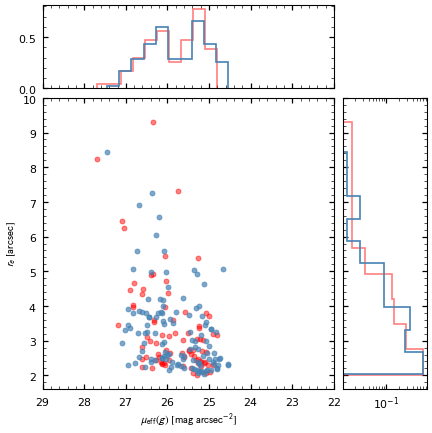

In [351]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((udg_cat['mag_circ'][:, 0] - udg_cat['mag_circ'][:, 2]) > 0.8)

ax.scatter(udg_cat[red]['SB_eff_avg'][:, 0], 
           udg_cat[red]['rhalf_circularized'] * 0.168, 
           color='r', alpha=0.5)
ax.scatter(udg_cat[~red]['SB_eff_avg'][:, 0], 
            udg_cat[~red]['rhalf_circularized'] * 0.168,
            color='steelblue', alpha=0.7)
ax.set_xlim(29, 22)
ax.set_ylim(1.6, 10)
ax.set_xlabel(r'$\mu_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(udg_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(udg_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(udg_cat[red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(udg_cat[~red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

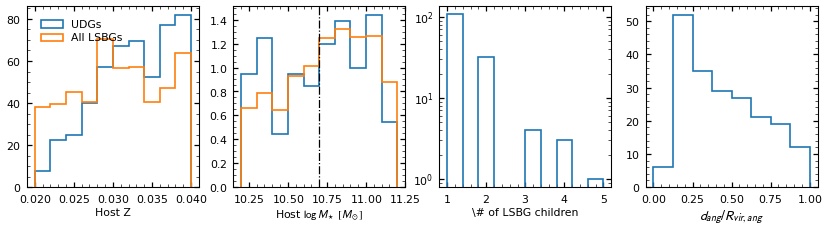

In [352]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(udg_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel('Host Z')
plt.legend(loc='upper left')

plt.sca(axes[1])
plt.hist(udg_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(udg_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('\# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

### UDG plots

In [353]:
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

In [354]:
# kz.set_matplotlib(dpi=100, fontsize=15)

In [355]:
gi_color = udg_cat['mag_circ'][:, 0] - udg_cat['mag_circ'][:, 2]

(-12.0, -16.0)

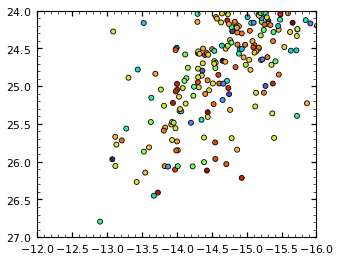

In [356]:
sct = plt.scatter(udg_cat['V_abs'], 
                  udg_cat['SB_0'][:, 0], 
            c=gi_color,
            label='UDGs')

plt.ylim(27, 24)
plt.xlim(-12, -16)

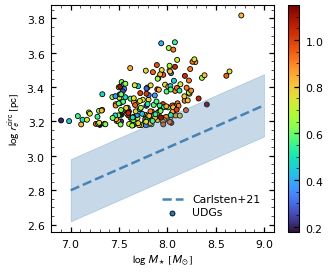

In [357]:
sct = plt.scatter(udg_cat['log_m_star'], 
            np.log10(udg_cat['rhalf_circularized_phys']) + 3, 
            c=gi_color,
            label='UDGs')

plt.colorbar()

x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(loc='lower right')

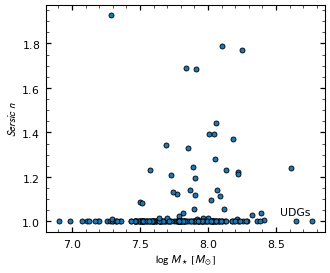

In [359]:
sct = plt.scatter(udg_cat['log_m_star'], 
            udg_cat['sersic_n'], 
            label='UDGs')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$Sersic\ n$')
plt.legend(loc='lower right')

In [360]:
from scipy.stats import binned_statistic

In [361]:
quench_frac, bin_edges, _ = binned_statistic(udg_cat['log_m_star'], (gi_color > 0.8), 
                                             statistic='mean', range=(7, 9), bins=8)
num, bin_edges, _ = binned_statistic(udg_cat['log_m_star'], (gi_color > 0.8), 
                                             statistic='count', range=(7, 9), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

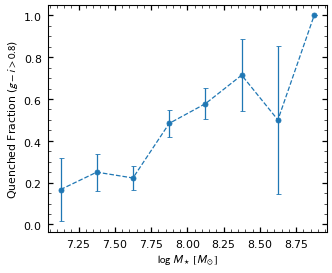

In [362]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [363]:
quench_frac, bin_edges, _ = binned_statistic(udg_cat['host_stellar_mass'], (gi_color > 0.8), 
                                             statistic='mean', range=(10.2, 11.2), bins=8)
num, bin_edges, _ = binned_statistic(udg_cat['host_stellar_mass'], (gi_color > 0.8), 
                                             statistic='count', range=(10.2, 11.2), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

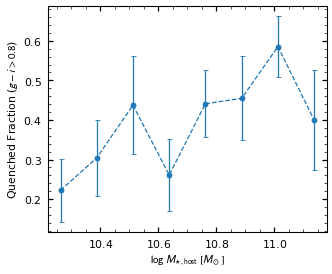

In [364]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_{\star, \rm host}\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [365]:
quench_frac, bin_edges, _ = binned_statistic(udg_cat['host_halo_mass'], (gi_color > 0.8), 
                                             statistic='mean', range=(11.7, 13.5), bins=8)
num, bin_edges, _ = binned_statistic(udg_cat['host_halo_mass'], (gi_color > 0.8), 
                                             statistic='count', range=(11.7, 13.5), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

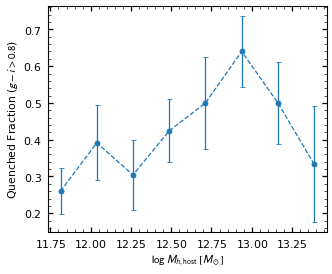

In [366]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_{h, \rm host}\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [266]:
yagi_cat = Table.read('./Catalog/Yagi+16.fits')

In [221]:
flag = (yagi_cat['Re1'].data.data > 1.5)# & (yagi_cat['SuBr0'].data.data > 24.5)
yagi_cat = yagi_cat[flag]

In [222]:
yagi_cat['log_m_star'] = (4.83 - yagi_cat['Rmag1'] + 35.05) / (2.5)

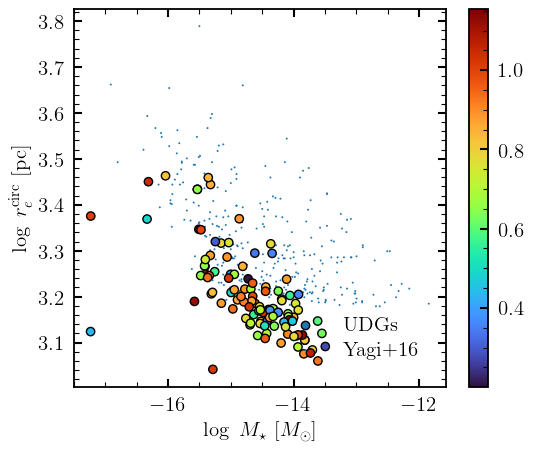

In [223]:
sct = plt.scatter(udg_cat['abs_mag'][:, 1], 
            np.log10(udg_cat['rhalf_circ_phys']) + 3, 
            c=gi_color,
            label='UDGs')
plt.colorbar()

#x = np.linspace(7, 9)
# plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
#                  mass_size_carlsten(x) + 0.181, 
#                  color='steelblue', alpha=0.3)
# plt.plot(x, mass_size_carlsten(x), ls='--', 
#          color='steelblue', lw=3, label='Carlsten+21')


plt.scatter(yagi_cat['Rmag1'] - 35.05, np.log10(yagi_cat['Re1']) + 3, 
            label='Yagi+16', edgecolor='none', s=2, zorder=0)

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(loc='lower right')

In [226]:
yagi_cat = Table.read('./Catalog/Yagi+16.fits')

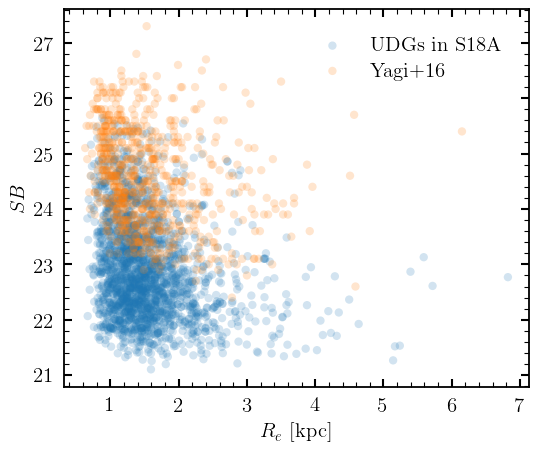

In [227]:
plt.scatter(cuts_cat['rhalf_circ_phys'], cuts_cat['SB_0'][:, 1], label='UDGs in S18A', alpha=0.2, edgecolor='none')
plt.scatter(yagi_cat['Re1'], yagi_cat['SuBr0'], label='Yagi+16', alpha=0.2, edgecolor='none')
#plt.scatter(cuts_cat['log_m_star'][flag], cuts_cat['rhalf_ellip_phys'][flag])


plt.xlabel(r'$R_e\ [\rm kpc]$')
plt.ylabel(r'$SB$')
plt.legend()